# 01 — Exploratory Data Analysis (EDA)
**Dataset:** Kaggle Credit Card Fraud Detection (`creditcard.csv`)  
**Goal:** Understand structure, class imbalance, and basic patterns that differentiate *fraud* vs *legit* transactions.

Key checks:
1. Schema overview (rows, columns, dtypes, missingness)
2. Class imbalance (0=legit, 1=fraud)
3. Descriptives by class
4. Distributions: `Amount`, `Time`, selected `V*` components
5. Simple correlations with `Class`
6. Quick anomalies sanity checks (duplicates, extreme values)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", 50)

sns.set(context="notebook", style="whitegrid")

## Load dataset
The dataset contains 284,807 transactions and 31 columns:  
`Time`, `Amount`, `Class`, and 28 anonymised PCA-like features `V1..V28`.  
`Class=1` denotes *fraud*.


In [2]:
PATH = "../data/creditcard.csv"
df = pd.read_csv(PATH)
df.shape, df.columns.tolist()[:10]


((284807, 31), ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'])

## Schema & missingness
We inspect dtypes and nulls. The Kaggle version typically has **no missing values**, but we verify.


In [3]:
df.info()
df.isna().sum().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

0

## Class balance
The dataset is **highly imbalanced**. We compute counts and proportions.


,count,prop
Class,,
legit,284315,0.998
fraud,492,0.002


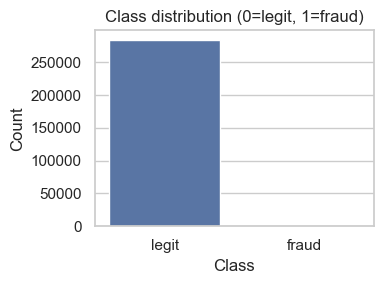

In [4]:
counts = df['Class'].value_counts().rename({0:"legit", 1:"fraud"})
props  = (counts / counts.sum()).round(4)
display(pd.DataFrame({"count": counts, "prop": props}))

plt.figure(figsize=(4,3))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class distribution (0=legit, 1=fraud)")
plt.ylabel("Count"); plt.xlabel("Class")
plt.tight_layout(); plt.show()


## Descriptive statistics (overall & by class)
We look at summary stats overall and then compare *fraud vs legit* for `Amount` and `Time`.

In [5]:
display(df.describe().T[['mean','std','min','max']].head(12))

byc = df.groupby('Class')[['Amount','Time']].agg(['count','mean','median','std','min','max'])
byc


,mean,std,min,max
Time,9.481e+04,47488.146,0.000,172792.000
V1,1.168e-15,1.959,-56.408,2.455
V2,3.417e-16,1.651,-72.716,22.058
V3,-1.380e-15,1.516,-48.326,9.383
V4,2.074e-15,1.416,-5.683,16.875
V5,9.604e-16,1.380,-113.743,34.802
V6,1.487e-15,1.332,-26.161,73.302
V7,-5.556e-16,1.237,-43.557,120.589
V8,1.213e-16,1.194,-73.217,20.007
V9,-2.406e-15,1.099,-13.434,15.595


Amount                                            Time             \
        count     mean median      std  min       max   count       mean   
Class                                                                      
0      284315   88.291  22.00  250.105  0.0  25691.16  284315  94838.202   
1         492  122.211   9.25  256.683  0.0   2125.87     492  80746.807   

                                            
        median        std    min       max  
Class                                       
0      84711.0  47484.016    0.0  172792.0  
1      75568.5  47835.365  406.0  170348.0

## Basic hygiene checks
- Duplicates (row-level)
- Constant/near-zero-variance columns
- Obvious invalid values (negative amounts)


In [6]:
dup_rows = df.duplicated().sum()
neg_amount = (df['Amount'] < 0).sum()
nzv = df.drop(columns=['Class']).nunique().sort_values().head(5)

print(f"Duplicate rows: {dup_rows}")
print(f"Negative Amount values: {neg_amount}")
nzv

Duplicate rows: 1081
Negative Amount values: 0


Amount     32767
Time      124592
V2        275663
V27       275663
V26       275663
dtype: int64

## Distributions: `Amount` & `Time`
`Time` is seconds from the first transaction; `Amount` is the transaction value.  
We compare distributions for fraud vs legit using random subsamples for readability.


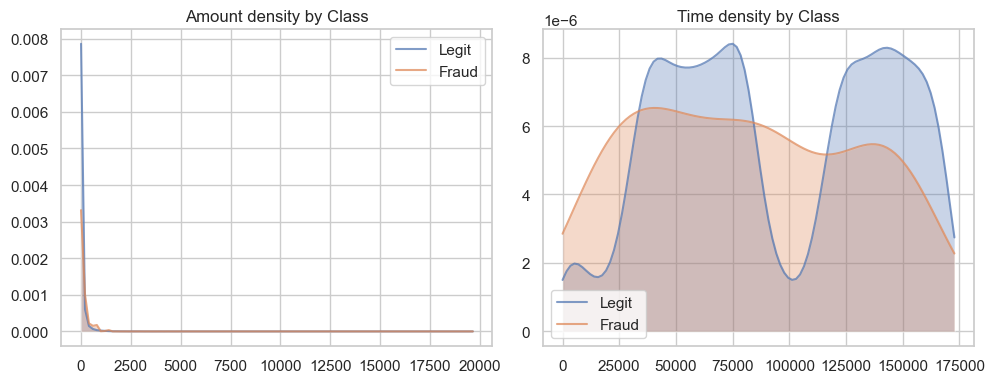

In [7]:
from scipy import stats

sample = df.sample(50000, random_state=425)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Separate the data
legit_amount = sample[sample['Class'] == 0]['Amount']
fraud_amount = sample[sample['Class'] == 1]['Amount']
legit_time = sample[sample['Class'] == 0]['Time']
fraud_time = sample[sample['Class'] == 1]['Time']

# Plot Amount KDE
x_range_amount = np.linspace(min(sample['Amount']), max(sample['Amount']), 100)
kde_legit_amount = stats.gaussian_kde(legit_amount)
kde_fraud_amount = stats.gaussian_kde(fraud_amount)

axes[0].plot(x_range_amount, kde_legit_amount(x_range_amount), label='Legit', alpha=0.7)
axes[0].plot(x_range_amount, kde_fraud_amount(x_range_amount), label='Fraud', alpha=0.7)
axes[0].fill_between(x_range_amount, kde_legit_amount(x_range_amount), alpha=0.3)
axes[0].fill_between(x_range_amount, kde_fraud_amount(x_range_amount), alpha=0.3)
axes[0].set_title("Amount density by Class")
axes[0].legend()

# Plot Time KDE
x_range_time = np.linspace(min(sample['Time']), max(sample['Time']), 100)
kde_legit_time = stats.gaussian_kde(legit_time)
kde_fraud_time = stats.gaussian_kde(fraud_time)

axes[1].plot(x_range_time, kde_legit_time(x_range_time), label='Legit', alpha=0.7)
axes[1].plot(x_range_time, kde_fraud_time(x_range_time), label='Fraud', alpha=0.7)
axes[1].fill_between(x_range_time, kde_legit_time(x_range_time), alpha=0.3)
axes[1].fill_between(x_range_time, kde_fraud_time(x_range_time), alpha=0.3)
axes[1].set_title("Time density by Class")
axes[1].legend()

plt.tight_layout()
plt.show()

## Boxplots: Amount and Time by Class
Boxplots highlight differences in central tendency and spread between classes.


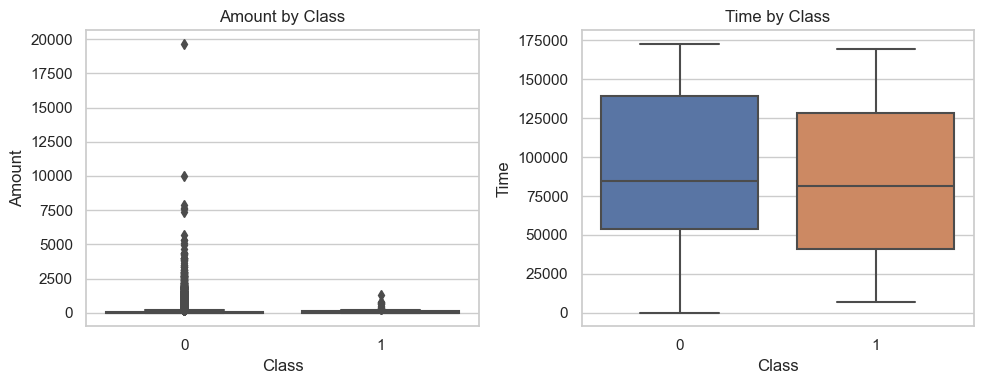

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=sample, x="Class", y="Amount", ax=axes[0])
axes[0].set_title("Amount by Class")
sns.boxplot(data=sample, x="Class", y="Time", ax=axes[1])
axes[1].set_title("Time by Class")
plt.tight_layout(); plt.show()

## Distributions of selected `V*` components
The `V1..V28` columns are anonymised components (PCA-like).  
We plot a few that often show separation (your results may vary): `V3`, `V4`, `V10`, `V14`.


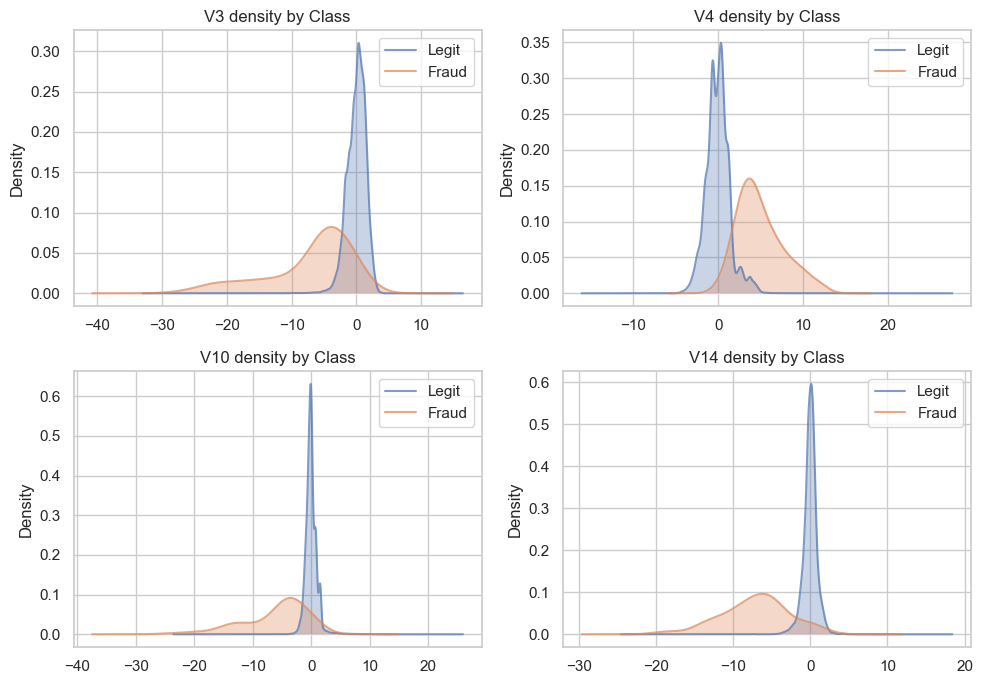

In [9]:
cols = ["V3", "V4", "V10", "V14"]  
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  
for col, ax in zip(cols, axes.ravel()):  
    # Plot density for each class separately
    sample[sample['Class'] == 0][col].plot.density(ax=ax, label='Legit', alpha=0.7)
    sample[sample['Class'] == 1][col].plot.density(ax=ax, label='Fraud', alpha=0.7)
    ax.fill_between(ax.lines[0].get_xdata(), ax.lines[0].get_ydata(), alpha=0.3)
    ax.fill_between(ax.lines[1].get_xdata(), ax.lines[1].get_ydata(), alpha=0.3)
    ax.set_title(f"{col} density by Class")
    ax.legend()
plt.tight_layout(); plt.show()

## Correlation with `Class`
Because `Class` is binary, Pearson correlation is equivalent to point-biserial correlation.  
We compute correlations between each feature and `Class` and show the top signals.


In [10]:
corr = df.corr(numeric_only=True)['Class'].drop('Class').sort_values(key=np.abs, ascending=False)
corr.head(12).to_frame("corr_with_Class")


,corr_with_Class
V17,-0.326
V14,-0.303
V12,-0.261
V10,-0.217
V16,-0.197
V3,-0.193
V7,-0.187
V11,0.155
V4,0.133
V18,-0.111


## Fraud vs Legit: side-by-side summary table
Simple per-class summaries to identify directional differences.


In [11]:
summary_cols = ["Amount","Time","V3","V4","V10","V14"]
summary = (df.groupby("Class")[summary_cols]
             .agg(['mean','median','std','min','max'])
             .round(3))
summary


Amount                                      Time                      \
          mean median      std  min       max       mean   median        std   
Class                                                                          
0       88.291  22.00  250.105  0.0  25691.16  94838.202  84711.0  47484.016   
1      122.211   9.25  256.683  0.0   2125.87  80746.807  75568.5  47835.365   

                           V3                                  V4         \
         min       max   mean median    std     min    max   mean median   
Class                                                                      
0        0.0  172792.0  0.012  0.182  1.459 -48.326  9.383 -0.008 -0.022   
1      406.0  170348.0 -7.033 -5.075  7.111 -31.104  2.250  4.542  4.177   

                               V10                                  V14  \
         std    min     max   mean median    std     min     max   mean   
Class                                                                     
0      1.399 -5.683  16.875  0.010 -0.092  1.044 -14.741  23.745  0.012   
1      2.873 -1.313  12.115 -5.677 -4.579  4.897 -24.588   4.031 -6.972   

                                     
      median    std     min     max  
Class                                
0      0.052  0.897 -18.392  10.527  
1     -6.730  4.279 -19.214   3.442